### Подготовим данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

sns.set_theme()
pd.set_option('display.float_format', lambda x: '%.5f' % x) # для удобного отображения describe

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
trips19 = pd.read_csv('/content/drive/MyDrive/trips/tripdata_2019-05.csv')

In [12]:
trips20 = pd.read_csv('/content/drive/MyDrive/trips/tripdata_2020-05.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Посмотрим, какие пропущенные значения есть в данных.

In [13]:
for el in trips19.columns:
    print(el, trips19[el].isna().sum())

VendorID 0
tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 0
trip_distance 0
RatecodeID 0
store_and_fwd_flag 0
PULocationID 0
DOLocationID 0
payment_type 0
fare_amount 0
extra 0
mta_tax 0
tip_amount 0
tolls_amount 0
improvement_surcharge 0
total_amount 0
congestion_surcharge 0


In [14]:
for el in trips20.columns:
    print(el, trips20[el].isna().sum())

VendorID 58891
tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 58891
trip_distance 0
RatecodeID 58891
store_and_fwd_flag 58891
PULocationID 0
DOLocationID 0
payment_type 58891
fare_amount 0
extra 0
mta_tax 0
tip_amount 0
tolls_amount 0
improvement_surcharge 0
total_amount 0
congestion_surcharge 0


На данный момент из пропущенных данных для нас интерес может представлять только колонка о количестве пассажиров.

Посмотрим на самое частое значение и заменим на него все пропущенные значения.

In [15]:
trips20.VendorID = trips20.VendorID.fillna(trips20['VendorID'].value_counts().idxmax())
trips20.passenger_count = trips20.passenger_count.fillna(trips20['passenger_count'].value_counts().idxmax())
trips20.RatecodeID = trips20.RatecodeID.fillna(trips20['RatecodeID'].value_counts().idxmax())
trips20.store_and_fwd_flag = trips20.store_and_fwd_flag.fillna(trips20['store_and_fwd_flag'].value_counts().idxmax())
trips20.payment_type = trips20.payment_type.fillna(trips20['payment_type'].value_counts().idxmax())

Преобразуем формат ячеек с временем для удобства.

In [16]:
trips19['tpep_pickup_datetime'] = pd.to_datetime(trips19.tpep_pickup_datetime)
trips19['tpep_dropoff_datetime'] = pd.to_datetime(trips19.tpep_dropoff_datetime)

In [17]:
trips20['tpep_pickup_datetime'] = pd.to_datetime(trips20.tpep_pickup_datetime)
trips20['tpep_dropoff_datetime'] = pd.to_datetime(trips20.tpep_dropoff_datetime)

Удалим данные, в которых начало во времени находится после конца, а также те строки, в которых id районов посадки/высадки больше 263(их именно столько).

In [18]:
trips19 = trips19[trips19.tpep_pickup_datetime <= trips19.tpep_dropoff_datetime]
trips19 = trips19[trips19.PULocationID <= 263]
trips19 = trips19[trips19.DOLocationID <= 263]

In [19]:
trips20 = trips20[trips20.tpep_pickup_datetime <= trips20.tpep_dropoff_datetime]
trips20 = trips20[trips20.PULocationID <= 263]
trips20 = trips20[trips20.DOLocationID <= 263]

Введём новые колонки: 

1. с датой начала поездки; 

2. с часом начала и конца;

3. с днём недели начала поездки; 

4. с временем продолжительности поездки(день конца поездки игнорируем, т.к. почти все поездки будут в промежутке одного дня);

5. временем поездки в секундах;

6. средней скоростью в м/с.

In [20]:
MILES_TO_KM = 1609.34

In [21]:
trips19['trip_pickup_day'] = trips19.tpep_pickup_datetime.dt.day
trips19['week_day'] = trips19.tpep_pickup_datetime.dt.dayofweek
trips19['trip_pickup_hour'] = trips19.tpep_pickup_datetime.dt.hour
trips19['trip_dropoff_hour'] = trips19.tpep_dropoff_datetime.dt.hour
trips19['trip_duration'] = trips19.tpep_dropoff_datetime - trips19.tpep_pickup_datetime
trips19['trip_duration_secs'] = trips19.trip_duration.dt.seconds
trips19['trip_distance'] = trips19['trip_distance'] * MILES_TO_KM
trips19['average_velocity'] = trips19['trip_distance'] / trips19['trip_duration_secs']

In [22]:
trips20['trip_pickup_day'] = trips20.tpep_pickup_datetime.dt.day
trips20['week_day'] = trips20.tpep_pickup_datetime.dt.dayofweek
trips20['trip_pickup_hour'] = trips20.tpep_pickup_datetime.dt.hour
trips20['trip_dropoff_hour'] = trips20.tpep_dropoff_datetime.dt.hour
trips20['trip_duration'] = trips20.tpep_dropoff_datetime - trips20.tpep_pickup_datetime
trips20['trip_duration_secs'] = trips20.trip_duration.dt.seconds
trips20['trip_distance'] = trips20['trip_distance'] * MILES_TO_KM
trips20['average_velocity'] = trips20['trip_distance'] / trips20['trip_duration_secs']

Посмотрим, есть ли в данных нереальные случаи.

Установим ограничение для средней скорости в 50 м/с сверху и 0.1 м/с снизу, а также удалим строки, в которых преодолено нулевое расстояние за ненулевое время, при этом получена некоторая сумма за поездку.

Так же удалим строки с отрицательной стоимостью поездки.

In [23]:
trips19 = trips19[trips19.average_velocity <= 50]
trips19 = trips19[trips19.average_velocity >= 1]
trips19 = trips19.drop(trips19[(trips19.trip_distance == 0) & (trips19.total_amount > 0) & (trips19.trip_duration_secs > 0)].index)
trips19 = trips19[trips19.total_amount >= 0]
trips19 = trips19[trips19.VendorID < 3]

In [24]:
trips20 = trips20[trips20.average_velocity <= 50]
trips20 = trips20[trips20.average_velocity >= 1]
trips20 = trips20.drop(trips20[(trips20.trip_distance == 0) & (trips20.total_amount > 0) & (trips20.trip_duration_secs > 0)].index)
trips20 = trips20[trips20.total_amount >= 0]
trips20 = trips20[trips20.VendorID < 3]

В последний понедельник мая проводится федеральный праздник День Памяти, который является государственным выходным. Установим для дат 27.05.19 и 25.05.20 значение 1 в новой колонке, 0 всем остальным.

In [25]:
trips19['is_holiday'] = [x.date().day == 27 for x in trips19['tpep_pickup_datetime']]
trips20['is_holiday'] = [x.date().day == 25 for x in trips20['tpep_pickup_datetime']]

Посмотрим на некоторые статистики, которые может предоставить python.

In [26]:
trips19.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_pickup_day,week_day,trip_pickup_hour,trip_dropoff_hour,trip_duration,trip_duration_secs,average_velocity
count,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825.00000,7336825,7336825.00000,7336825.00000
mean,1.63076,1.57271,4875.00001,1.03650,162.61978,160.66925,1.28009,13.21114,1.20345,0.49863,2.23998,0.38749,0.29997,19.30241,2.31638,15.47562,2.99066,13.97302,14.01989,0 days 00:14:59.757923488,899.74615,5.00345
std,0.48260,1.22277,6172.17999,0.50351,65.81508,69.81401,0.46402,11.15887,1.28250,0.02630,2.66822,1.67773,0.00301,13.93306,0.65217,8.93420,1.84339,5.99837,6.08824,0 days 00:12:26.533958316,745.51501,2.71636
min,1.00000,0.00000,16.09340,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0 days 00:00:02,2.00000,1.00005
25%,1.00000,1.00000,1609.34000,1.00000,114.00000,107.00000,1.00000,6.50000,0.00000,0.50000,0.00000,0.00000,0.30000,11.30000,2.50000,8.00000,2.00000,10.00000,10.00000,0 days 00:06:54,414.00000,3.21868
50%,2.00000,1.00000,2703.69120,1.00000,162.00000,162.00000,1.00000,9.50000,0.50000,0.50000,1.96000,0.00000,0.30000,14.80000,2.50000,15.00000,3.00000,15.00000,15.00000,0 days 00:11:31,691.00000,4.36705
75%,2.00000,2.00000,4988.95400,1.00000,233.00000,233.00000,2.00000,15.00000,2.50000,0.50000,3.00000,0.00000,0.30000,20.80000,2.50000,23.00000,4.00000,19.00000,19.00000,0 days 00:18:55,1135.00000,5.98535
max,2.00000,9.00000,319196.49560,99.00000,263.00000,263.00000,4.00000,4016.50000,23.00000,3.30000,444.00000,706.68000,0.30000,4020.30000,2.75000,31.00000,6.00000,23.00000,23.00000,1 days 06:10:50,51841.00000,49.97424


In [27]:
trips20.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_pickup_day,week_day,trip_pickup_hour,trip_dropoff_hour,trip_duration,trip_duration_secs,average_velocity
count,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471,330471.00000,330471.00000
mean,1.64588,1.26830,5997.37083,1.01357,152.11257,147.27823,1.34259,13.34287,0.98605,0.49594,1.45781,0.39342,0.29993,18.14100,1.90850,16.38488,3.00259,13.10049,13.15487,0 days 00:11:47.171597507,707.17160,7.45323
std,0.47825,0.91647,7241.93656,0.34777,70.28768,74.10171,0.50750,12.05296,1.25061,0.04519,2.41877,1.74630,0.00449,13.44482,1.06249,8.83033,1.87694,5.30301,5.33937,0 days 00:09:58.915852939,598.91585,3.34638
min,1.00000,0.00000,16.09340,1.00000,1.00000,1.00000,1.00000,-10.86000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0 days 00:00:02,2.00000,1.00236
25%,1.00000,1.00000,1770.27400,1.00000,90.00000,75.00000,1.00000,6.00000,0.00000,0.50000,0.00000,0.00000,0.30000,10.30000,2.50000,9.00000,1.00000,9.00000,9.00000,0 days 00:05:14,314.00000,5.16873
50%,2.00000,1.00000,3283.05360,1.00000,142.00000,143.00000,1.00000,9.00000,0.00000,0.50000,1.00000,0.00000,0.30000,13.80000,2.50000,16.00000,3.00000,14.00000,14.00000,0 days 00:08:55,535.00000,6.63645
75%,2.00000,1.00000,6920.16200,1.00000,230.00000,230.00000,2.00000,15.50000,2.50000,0.50000,2.46000,0.00000,0.30000,20.76000,2.50000,24.00000,4.00000,17.00000,17.00000,0 days 00:15:13,913.00000,8.83707
max,2.00000,6.00000,491009.63400,99.00000,263.00000,263.00000,4.00000,801.50000,7.00000,3.30000,442.18000,200.00000,0.30000,1042.82000,2.50000,31.00000,6.00000,23.00000,23.00000,0 days 11:56:00,42960.00000,49.97082


Из describe можем сделать несколько выводов:
0. Среднее количество пассажиров снизилось с 1.57 до 1.27 из-за социального дистанцирования. Также максимальное количество уменьшилось от 9 до 6 человек(среди жёлтых такси так же есть минивены, потому такое большое количество неудивительно).
1. Средняя дистанция в 20м году выросла с 5км до 6км. Можем сделать вывод, что люди стали чаще пользоваться такси для каких-то длительных поездок, ведь если расстояние небольшое, может быть рентабельнее просто пойти пешком, чтобы ни с кем зря не контактировать.
2. Несмотря на увеличение дистанции средняя продолжительность поездки уменьшилось(соответственно выросла средняя скорость) из-за меньшей загруженности дорог.


### Получим представление о районах Нью-Йорка.

В Нью-Йорке есть 5 основных районов: Manhattan, Queens, Brooklyn, Staten Island и Bronx.

![ny_map](pictures/ny_map.jpg)


Manhattan является главным туристическим местом, а также скоплением главных бизнес-центров Нью-Йорка. Тут очень развита инфраструктура  (не)активного времяпрепровождения.

Queens является одним из наиболее "спальных" районов города. Однако тут расположен Национальный аэропорт имени Джона Кеннеди - аэропорт с самым большим трафиком пассажирских и грузовых авиаперевозок в мире, что в купе с тем фактом, что тут происходит множество спортивных мероприятий, добавляет посещаемости приезжими.

Brooklyn - самый населённый район Нью-Йорка. При этом тут очень развита инфраструктура локальных мероприятий, что позволяет жителям не ездить куда-то, а "жить на месте".

В Bronx'е находится печально известный своей неблагополучностью квартал Camp Apache. Однако сейчас там всё спокойно. Более того, среди туристов имеют популярность несколько иностранных кварталов

Staten Island - самый тихий район с наименьшей численностью населения. Туристов сюда не тянет в силу того, что тут "почти не на что смотреть". Однако с его замечательной природой можно отдохнуть от суеты других районов.

### Визуализируем данные.

Тут мы чаще будем пытаться отследить тенденцию к поведению пользователей(например популярность одного дня недели относительно других), но иногда будем наблюдать и за численными показателями.


In [28]:
# зададим размер графиков
plt.rcParams['figure.dpi'] = 90

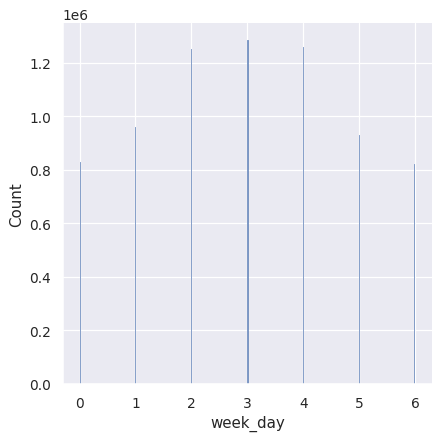

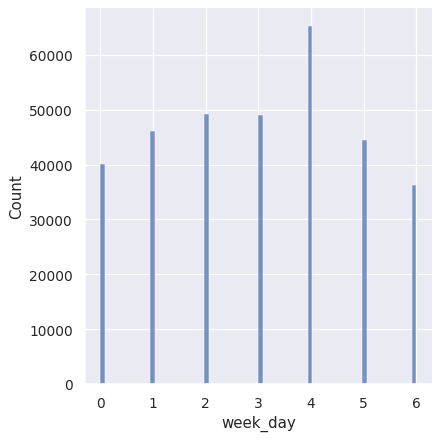

In [37]:
sns.displot(trips19, x='week_day')
sns.displot(trips20, x='week_day')

Выше видим выброс в пятницу в 2020м году. Возможно это объясняется режимом самоизоляции, который очень хочется нарушить в конце рабочей недели(либо в целом возвращение с работы домой, если это не является ежедневной рутиной).

В противоложность этому основная нагрузка в 19м году приходится на середину рабочей недели. Возможно, причина этому тот факт, что вторник является самым удачным днём для сложных задач, а дальше уже хочется немного поотлынивать, потому жители занимаются своими делами, в том числе разъездами([link](https://secretmag.ru/opinions/ponedelnik-kak-socialnyj-konstrukt-chto-ne-tak-s-dnyami-nedeli.htm)).

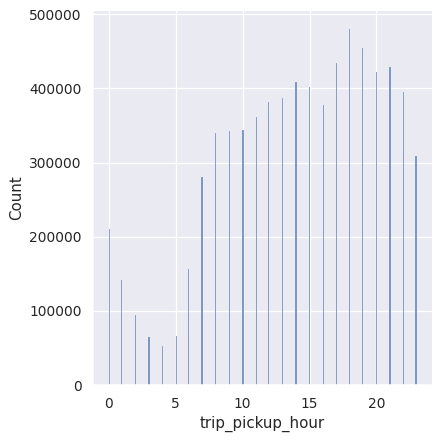

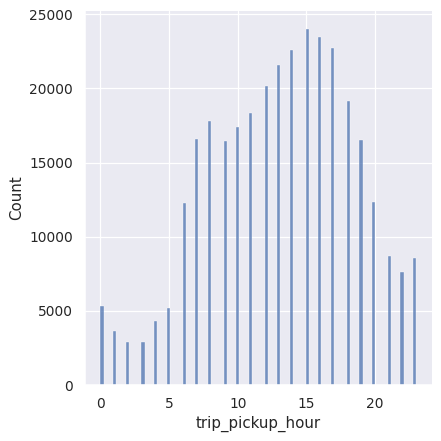

In [38]:
sns.displot(trips19.trip_pickup_hour)
sns.displot(trips20.trip_pickup_hour)

В 19 году видим основную нагрузку на 6-7 часов вечера, т.к. жители возвращаются с работы попутно заезжая по делам.

Однако в 20м году пик приходится на 3 часа дня. Возможно это потому что весь город подумал, что днём будет мало людей на улицах из-за работы и побежал делать свои дела.

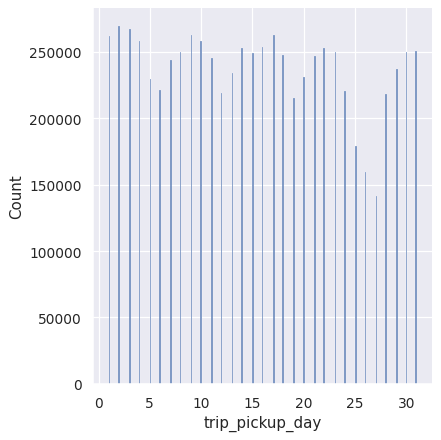

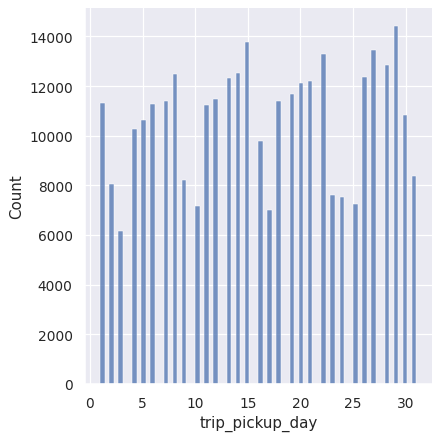

In [39]:
sns.displot(trips19, x='trip_pickup_day')
sns.displot(trips20, x='trip_pickup_day')

В оба года видим снижения использования средств передвижение во время выходных. Однако в 19м году имеется тенденция к постепенному снижению использования такси в течение рабочих дней(люди начинают готовится к отпуску и собственно отдыхать), тогда как в 20м году правило обратно: использование повышается, - тут это обуславливается тем, что люди уже устали сидеть некоторое время на карантине и начинают "подзабивать" на рекомендации самоизоляции.

Также отметим резкое(даже относительно выходных) снижение поездок 27.05.2019 и 25.05.2020, т.к. в этот день федеральный праздник День Памяти, являющийся выходным.

(0.0, 5000.0)

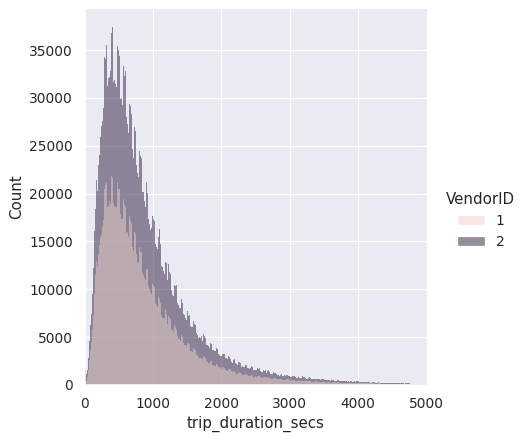

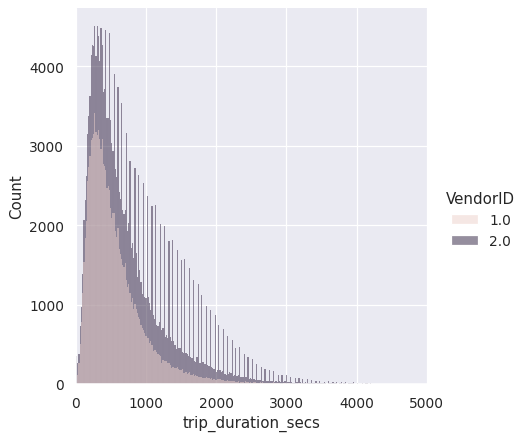

In [40]:
sns.displot(trips19, x='trip_duration_secs', hue='VendorID')
plt.xlim(0, 5000)
sns.displot(trips20, x='trip_duration_secs', hue='VendorID')
plt.xlim(0, 5000)

Похоже на распределение Пуассона или Максвелла.

На 2м графике существуют видимые выбросы, но это скорее из-за малого количества наблюдений. На 1м графике тенденция видна гораздо лучше и без выбросов.

Легко увидеть, что пользователи совершают очень много коротких поездок(до 30 минут) и очень мало длинных(более часа). На ум приходят две причины: немалая стоимость длинной поездки + средний пассажир ездит ради скорости  и независимости от большинства других факторов(расписание общественного транспорта, движение от точки до точки).

Также видим, что в целом за год появилась тенденция ещё больше использовать в качестве перевозчика компанию №1. Возможно это связано с какими-то локальными улучшениями.

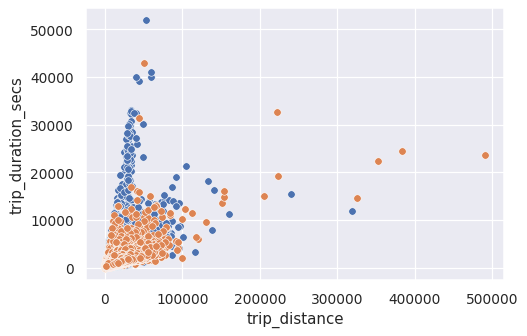

In [41]:
sns.scatterplot(data=trips19, x=trips19['trip_distance'], y=trips19['trip_duration_secs'])
sns.scatterplot(data=trips20, x=trips20['trip_distance'], y=trips20['trip_duration_secs'])

По графикам зависимости времени поездки от расстояния можем понять, что в целом они распределены примерно одинаково относительно друг друга(этому виной в том числе и то, как мы убирали выбросы), т.е. эпидемия повлияла в данном случае только на количество поездок и уменьшение числа длительных поездок.

Однако есть очень много поездок с короткими дистанциями, но значительным временем. Это может объясняться большим трафиком в загруженные части дня. Как видим, систематически такой проблемы в 20м году не наблюдалось в силу того, что в целом загруженность узлов была меньше $\implies$ меньше пробок.

(0.0, 25.0)

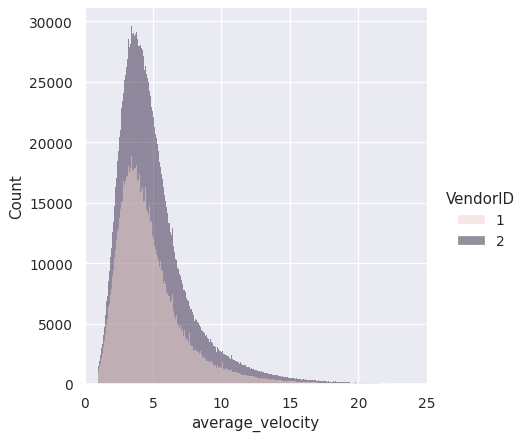

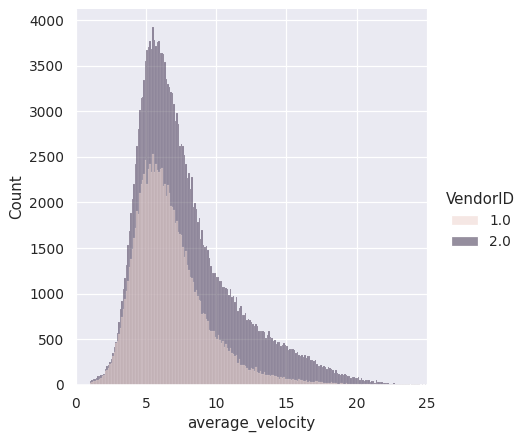

In [42]:
sns.displot(trips19, x='average_velocity', hue='VendorID')
plt.xlim(0, 25)
sns.displot(trips20, x='average_velocity', hue='VendorID')
plt.xlim(0, 25)

Видим уже знакомое распределение. Пики расположены около средних скоростей, которые составляют соответственно 18 и 27 км/ч, что вполне нормально для Нью-Йорка с его трафиком и пробками. Для передвижения со скоростью выше 48 км/ч(13.3 м/с) требуется либо быть каким-нибудь служебным автомобилем(скорая, полиция или пожарные), либо нарушать скоростной режим(чем, видимо, не пренебрегает некоторое количество водителей).

Тут же можем понять, что в 2020м году для быстрых переездом чаще использовался перевозчик №2. Вкупе с данными с графиков о времени переезда можем попробовать сделать вывод, что водители данной компании чаще нарушают: они быстрее ездят, но пассажиры немного опасаются использовать этого перевозчика.

![19fool](pictures/19.jpg)
![20fool](pictures/20.jpg)

Кажется, за весь период мы ничего конкретного не вынесем. Особенно из прошлого года. Однако в этом году можно заметить, что популярным осталось направления Manhatten(и собственно весь он сам) и 2 аэропорта в Queens, а также в 19м году аэропорт Ньюарк. Однако можем заметить, что и так малое количество поездок из Staten Island стало ещё меньше(возможно потому что там много русских, а раз Президент сказал самоизолироваться, нужно самоизолироваться).

![19weekday](pictures/19weekday.jpg)
![19weekend](pictures/19weekend.jpg)

Здесь отображены поездки за рабочие дни и за выходные в мае 19ого года. 

На выходных видим значительное уменьшение поездок в район Staten Island. Это, возможно, обусловлено тем, что много жителей едут в другие районы на работу, а вся инфраструктура для отдыха на выходных присутствует на месте. Более того, вспоминая, что этот район является довольно тихим, можно сделать вывод, что жители не хотят суеты ещё и в выходные.

Также можно заметить небольшое уменьшение трафика из аэропортов на выходных(вероятно потому Нью-Йорк популярный город даже больше для рабочих визитов, чем для отдыха).

Однако в целом плотность в центральных районах не изменилась.

![20weelday](pictures/20weekday.jpg)
![20weekend](pictures/20weekend.jpg)

В противоположность этому на выходных 20ого видно значительное снижение использования такси. Популярным остались Manhattan и аэропорты, но очевидно снижение переездов между дальними частями города. Также можем заметить, что из аэропорта Ньюарк почти полностью перестали ездить.

В целом можно понять, что Manhattan всегда имел большой трафик из-за множества туристов и большого количества бизнес-центров.

### Немного изменим представление категориальных данных

У нас есть несколько колонок, которые являются категориальными данными. Для линейной регрессии это не очень хорошо, потому сделаем следующим образом: для каждой категории заведём отдельную колонку и выставим в ней True, если у текущей колонки именно эта категория.

Таким образом будет легко поступить с payment_type, т.к. там всего 6 различных вариантов. Так сделаем для остальных фичей: VendorID, RatecodeID, store_and_fwd_flag. 

Для колонок PULocationID и DOLocationID так не пойдёт, потому что там значения от 1 до 263, что очень сильно нагрузит систему. Можно было бы распределить только по районам города: Manhattan, Staten Island, Brooklyn, Queens, Bronx и EWR(Newark Airport).

Также можем удалить время начала и конца поездок, т.к. уже некоторую информацию из них мы вынесли, а модели формат datetime не воспринимают. Также сейчас удалим trip_duration. trip_duration_secs удалим чуть позже, когда получим ответы для train- и test-выборок.

In [43]:
drop_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_duration']
trips19 = trips19.drop(columns=drop_columns)
trips20 = trips20.drop(columns=drop_columns)

In [44]:
columns = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type']
for column in columns:
    for val in set(trips19[column].values):
        trips19[column + str(val)] = trips19[column] == val
    for val in set(trips20[column].values):
        trips20[column + str(val)] = trips20[column] == val
    trips19 = trips19.drop(columns=column)
    trips20 = trips20.drop(columns=column)

In [45]:
boroughs = {
    'EWR': [1],
    'Manhattan': [4, 12, 13, 24,  41, 42, 43,
  45, 48,  50, 68, 74, 75, 79, 87, 88, 90, 100, 103, 103, 103, 107, 113, 114,
  116, 120, 125, 127, 128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153,
  158, 161, 162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224, 229, 230, 
  231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263],
    'Brooklyn': [11, 14, 17, 21, 22, 25, 26, 29, 33, 34, 35, 
  36, 37, 39, 40, 49, 52, 54, 55, 61, 62, 63, 65, 66, 67, 71, 72, 76, 77, 80,
  85, 89, 91, 97, 106, 108, 111, 112, 123, 133, 149, 150, 154, 155, 165, 177, 
  178, 181, 188, 189, 190, 195, 210, 217, 222, 225, 227, 228, 255, 256, 257],
    'Bronx': [3, 18, 20, 31, 32, 46, 47, 51, 58, 59, 60, 69, 
  78, 81, 94, 119, 126, 136, 147, 159, 167, 168, 169, 174, 182, 183, 184, 185, 
  199, 200, 208, 212, 213, 220, 235, 240, 241, 242, 247, 248, 250, 254, 259],
    'Queens': [2, 7, 8, 9, 
  10, 15, 16, 19, 27, 28, 30, 38, 53, 56, 56, 64, 70, 73, 82, 83, 86, 92, 93,
  95, 96, 98, 101, 102, 117, 121, 122, 124, 129, 130, 131, 132, 134, 135, 138,
  139, 145, 146, 157, 160, 171, 173, 175, 179, 180, 191, 192, 193, 196, 197, 
  198, 201, 203, 205, 207, 215, 216, 218, 219, 223, 226, 252, 253, 258, 260],
 '    Staten Island': [5, 6, 23, 44,
  84, 99, 109, 110, 115, 118, 156, 172, 176, 187, 204, 206, 214, 221, 245, 251]
}

In [46]:
columns = [('PULocationID', 'PU'), ('DOLocationID', 'DO')]
for column, abr in columns:
    for brg in boroughs:
        ids = boroughs[brg]
        trips19[brg + abr] = [True if x in ids else False for x in trips19[column]]
        trips20[brg + abr] = [True if x in ids else False for x in trips20[column]]
    trips19 = trips19.drop(columns=column)
    trips20 = trips20.drop(columns=column)


### Начнём обучать модели

Чётких правил по выбору размеров train- и test-выборок нет. Рекомендуется брать в каком-то из соотношений 90/10, 80/20, 70/30. По принципу Парето возьмём 80/20.

Гораздо большим значением обладает размер самой выборки. Проверим их.

In [47]:
print(trips19.shape, trips20.shape)

(7336825, 44) (330471, 44)


Имеем размеры в $7.3 \cdot 10^6$ и $3.3 \cdot 10^5$.
Это выборки с довольно большим и средним размером соответственно. Потому искусственно повышать размер train-выборки из-за недостаточности данных необходимости нет.

Чтобы не нагружать оперативную память пообучаем по очереди, но модели оставим.

In [48]:
def get_tr_ts(trips) -> tuple:
    train, test = train_test_split(trips, test_size=0.2)

    tr_ans = train['trip_duration_secs']
    tr_ans = np.array(tr_ans.values.tolist()).astype(float)

    train = train.drop(columns=['trip_duration_secs'])
    train = np.array(train.values.tolist()).astype(float)

    ts_ans = test['trip_duration_secs']
    ts_ans = np.array(ts_ans.values.tolist()).astype(float)

    test = test.drop(columns=['trip_duration_secs'])
    test = np.array(test.values.tolist()).astype(float)
    
    return train, test, tr_ans, ts_ans

In [49]:
train, test, tr_ans, ts_ans = get_tr_ts(trips19)

Для начала попробуем обучить линейную регрессию без параметров.

In [50]:
reg = LinearRegression(n_jobs=-1).fit(train, tr_ans)

Посмотрим, как регрессия умеет предсказывать данные для train-выборки.

In [51]:
predicted = reg.predict(train)

Построим график отклонений предсказания от ответа:

(-2000.0, 2000.0)

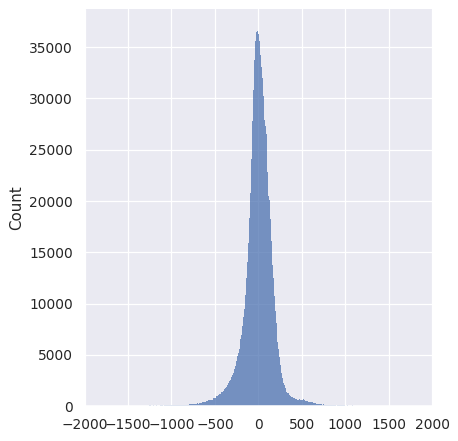

In [52]:
sns.displot(predicted - tr_ans)
plt.xlim(-2000, 2000)

In [53]:
np.mean(np.abs(predicted - tr_ans))

129.51671849919808

Среднее значение отклонение около 2.5 минуты. Учитывая, что средняя поездка около 15 минут, это и правда много, однако для самоощущения 2.5 минуты - не такой большой промежуток. Но это же средняя ошибка. На графике видно, что в обе стороны есть отклонения, причём немного больше в отрицательную: пользователю будет не очень приятно понять, что ехать на 10 минут дольше.

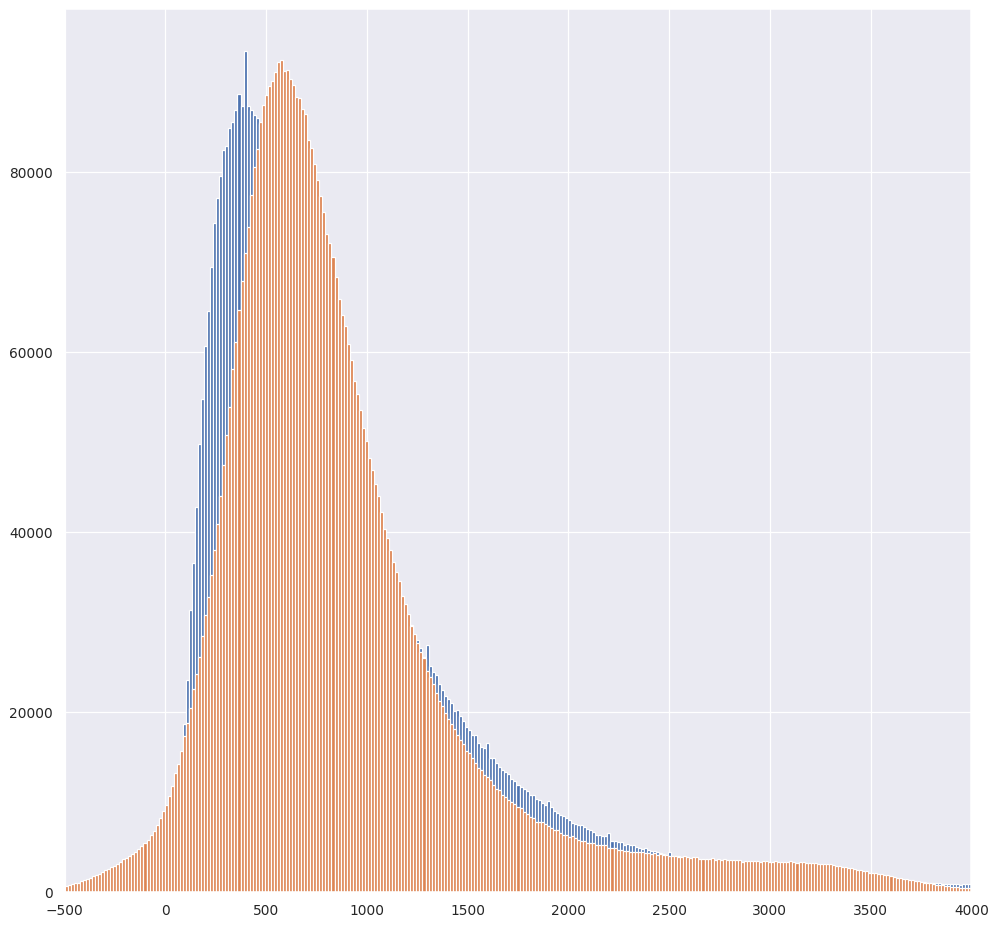

In [54]:
plt.figure(figsize=(13, 13))
plt.hist(tr_ans, bins=np.linspace(-500, 4000, 300))
plt.hist(predicted, bins=np.linspace(-500, 4000, 300))
plt.xlim(-500, 4000)
pass

Посмотрим на MSE:
$$
MSE = \dfrac{1}{N}\sum\limits_{i = 1}^{n} (y_i - \hat{y}_i)^2
$$

In [55]:
mean_squared_error(tr_ans, predicted)

57949.627165431666

Видим большое значение. Будем использовать его как отправную точку для оценки качества последующих моделей, т.к. тут мы знаем, что это не самый приемлемый результат. И очевидно можем сказать, что модель не переучилась.

Посмотрим, как наша модель предскажет значения для тестовой выборки:

In [56]:
predicted = reg.predict(test)

Построим аналогичные оценки.

(-2000.0, 2000.0)

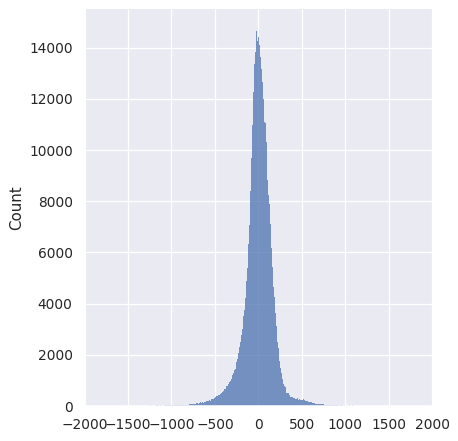

In [57]:
sns.displot(predicted - ts_ans)
plt.xlim(-2000, 2000)

In [58]:
np.mean(np.abs(predicted - ts_ans))

129.75937947691602

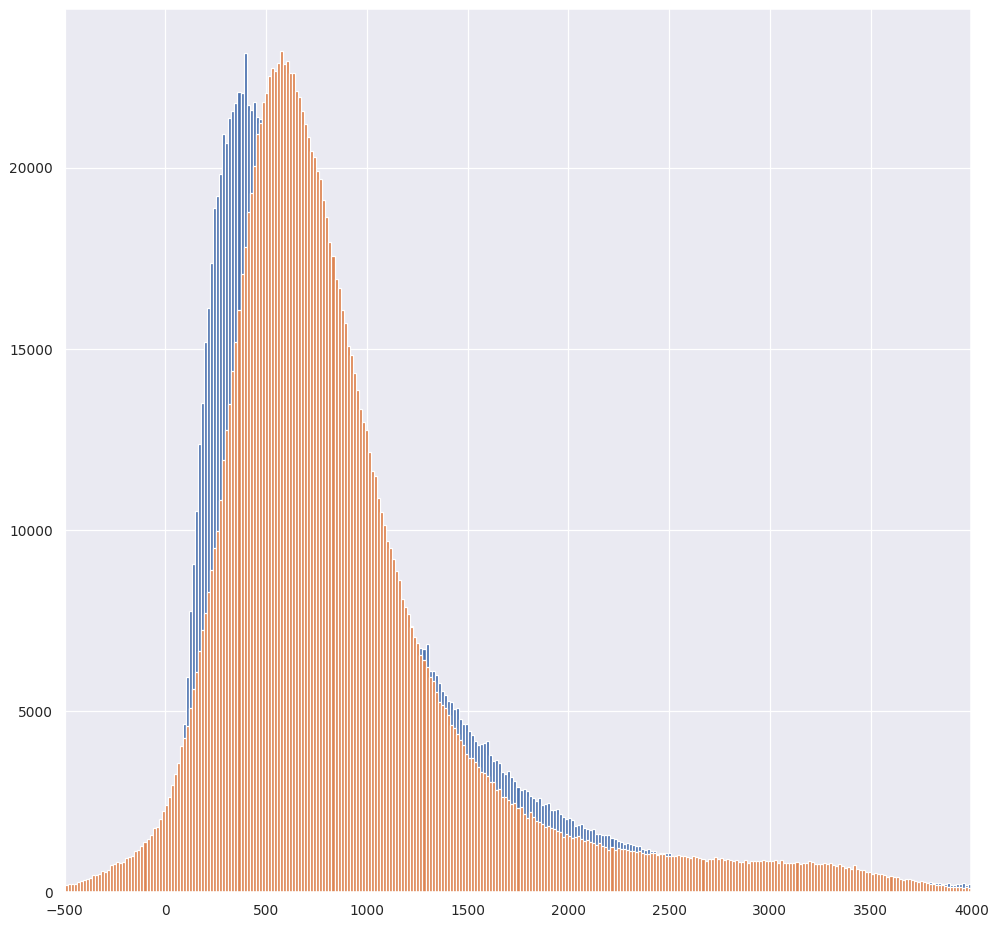

In [59]:
plt.figure(figsize=(13, 13))
plt.hist(ts_ans, bins=np.linspace(-500, 4000, 300))
plt.hist(predicted, bins=np.linspace(-500, 4000, 300))
plt.xlim(-500, 4000)
pass

In [60]:
mean_squared_error(ts_ans, predicted)

96783.11566553918

Ситуация почти аналогичная.

Посмотрим на коэффициенты фичей.

In [61]:
reg.coef_

array([ 9.99667237e-01,  4.56886705e-02, -2.76972691e+00, -2.88563027e+00,
       -6.88737322e+02, -5.88301772e+01, -7.61040381e+01, -2.10064540e+03,
        6.10141242e+01, -3.57480216e+01,  4.08486626e-01,  1.69389999e+00,
       -4.74489429e+00,  3.02262960e+00, -1.11126367e+02,  2.69253270e+00,
        1.12851202e+00, -1.12851202e+00,  8.25004586e+02,  2.27627682e+02,
       -1.66248148e+02, -4.50788871e+02, -7.03937382e+02,  6.84126127e+02,
       -4.15783995e+02,  3.85988271e+00, -3.85988271e+00, -1.83505778e+01,
       -1.05192579e+01,  1.85763236e+01,  1.02935120e+01, -1.05992639e+03,
        1.27203600e+02,  1.99889920e+02,  2.35400507e+02,  7.70529610e+01,
        1.57188751e+02, -1.04548297e+03,  4.42528249e+00, -6.06550026e+01,
       -1.76553920e+02,  1.66764197e+01, -1.07562928e+03])

Как видим, нет каких-то фичей с очень маленьким порядком коэффициентов, потому ничего выбросить не сможем.

Проверим для 20ого года.

In [62]:
train, test, tr_ans, ts_ans = get_tr_ts(trips20)

In [63]:
reg.fit(train, tr_ans)
pass

In [64]:
predicted = reg.predict(train)

# Параметры.